<a href="https://colab.research.google.com/github/MWCC8/Crunchbase-Acquisition-Prediction/blob/main/Crunchbase_Acquisition_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting if a Company on Crunchbase Will be Acquired

In the folllowing project, Crunchbase data is used to develop a machine learning classification model that predicts if a company will be acquired. This prediction is made using characteristics of the company, like it's total funding, country of origin, last round of funding, etc.

### Import required packages and import data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import scikitplot as skplt

In [2]:
data = pd.read_csv('investments_VC.csv', encoding='unicode_escape')
data.dropna(axis = 0, how = 'all', inplace = True)
data.rename(columns={' market ': 'market'}, inplace=True)
data.rename(columns={' funding_total_usd ': 'funding_total_usd'}, inplace=True)

### Pre-processing

In this step, that data is clean and pre-processed for the machine learning model. For instance, categorical variables are encoded with numbers so that the model can read them.

In [3]:
# status
data['status'] = data['status'].replace(['closed'],'not acquired')
data['status'] = data['status'].replace(['operating'],'not acquired')

status_mapper = {"acquired":1, "not acquired":0}

data["status"] = data["status"].replace(status_mapper)

# country
data['country_code'] = data['country_code'].apply(lambda x: 'international' if x != 'USA' else x)
data['country_code'] = data['country_code'].replace(['USA'],'domestic')

country_mapper = {"domestic":1, "international":0}

data["country_code"] = data["country_code"].replace(country_mapper)

# market
allowed_industries = [" Software ", " Biotechnology ", " E-Commerce ", " Mobile ", " Curated Web "]

data['market'] = data['market'].apply(lambda x: x if x in allowed_industries else 'other')

market_mapper = {" Software ":1, " Biotechnology ":2, " Mobile ":3, " E-Commerce ":4, " Curated Web ":5, "other":6}

data["market"] = data["market"].replace(market_mapper)

# regions
allowed_regions = ["SF Bay Area", "New York City", "Boston", "London", "Los Angeles"]

data['region'] = data['region'].apply(lambda x: x if x in allowed_regions else 'other')

regions_mapper = {"SF Bay Area":1, "New York City":2, "Boston":3, "London":4, "Los Angeles":5, "other":6}

data["region"] = data["region"].replace(regions_mapper)

# quarters
data['founded_quarter'] = data['founded_quarter'].str[-2:]
data['founded_quarter'].fillna("Q0", inplace=True)

mapper = {"Q1":1, "Q2":2, "Q3":3, "Q4":4, "Q0":5}

data["founded_quarter"] = data["founded_quarter"].replace(mapper)

# months
data['founded_month'] = data['founded_month'].str[-2:]
data['founded_month'].fillna("00", inplace=True)

mapper = {
    "01": 1, "02": 2, "03": 3,
    "04": 4, "05": 5, "06": 6,
    "07": 7, "08": 8, "09": 9,
    "10": 10, "11":11, "12": 4, "00":0
}

data["founded_month"] = data["founded_month"].replace(mapper)

data.loc[data['founded_year'] >= 2000, 'founded_year'] = 'new'

# founded year

allowed = ['new']

data['founded_year'] = data['founded_year'].apply(lambda x: x if x in allowed else 'old')

mapper = {"new":1, "old":0}

data["founded_year"] = data["founded_year"].replace(mapper)

# first_funding_at
data['first_funding_at'] = data['first_funding_at'].str[:4]
data['first_funding_at'].fillna("0000", inplace=True)

# last_funding_at
data['last_funding_at'] = data['last_funding_at'].str[:4]
data['last_funding_at'].fillna("0000", inplace=True)

# funding_total_usd
data['funding_total_usd'] = data['funding_total_usd'].str.replace(' ', '')
data['funding_total_usd'] = data['funding_total_usd'].str.replace(',', '')

status_mapper = {"-":0}

data["funding_total_usd"] = data["funding_total_usd"].replace(status_mapper)

In [4]:
# Remove unwanted columns

columns_to_remove = ['permalink','name','homepage_url','category_list','state_code','city',
                     'founded_at', 'secondary_market','round_F', 'round_G', 'round_H', 'post_ipo_debt',
                     'product_crowdfunding', 'equity_crowdfunding', 'post_ipo_equity', 'convertible_note',
                     'round_E', 'undisclosed', 'round_C', 'round_D', 'founded_year', 'grant', 'private_equity', 'angel', 'debt_financing']

data = data.drop(columns_to_remove, axis=1)

In [5]:
# Convert all columns to the interger datatype

object_columns = data.select_dtypes(include=['object']).columns
data[object_columns] = data[object_columns].astype(int)

print(data.dtypes)

market                 int64
funding_total_usd      int64
status               float64
country_code           int64
region                 int64
funding_rounds         int64
founded_month          int64
founded_quarter        int64
first_funding_at       int64
last_funding_at        int64
seed                   int64
venture                int64
round_A                int64
round_B                int64
dtype: object


In [6]:
# Remove rows that are missing a value for the target variable
data = data.dropna(subset=['status'])

In [7]:
data

,market,funding_total_usd,status,country_code,region,funding_rounds,founded_month,founded_quarter,first_funding_at,last_funding_at,seed,venture,round_A,round_B
0,6,1750000,1.0,1,2,1,4,2,2012,2012,1750000,0,0,0
1,6,4000000,0.0,1,5,2,0,5,2010,2010,0,4000000,0,0
2,6,40000,0.0,0,6,1,4,4,2012,2012,40000,0,0,0
3,6,1500000,0.0,0,4,1,11,2,2011,2011,1500000,0,0,0
4,6,60000,0.0,1,6,2,14,1,2014,2014,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49433,6,320000,0.0,0,4,1,13,1,2014,2014,320000,0,0,0
49434,6,1587301,0.0,0,6,1,0,5,2012,2012,0,1587301,1587301,0
49435,6,97398,0.0,0,6,5,4,2,2011,2014,71525,0,0,0
49436,6,9300000,0.0,0,6,1,0,5,2011,2011,9300000,0,0,0


### Create the Classification Model

In [8]:
# y, our target, is the status, i.e., if a company is acquired (1) or not (0)

y = data['status']

In [9]:
X = data.drop('status', axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

In [11]:
# Balance Data:
# Only ~9% of the rows has a value of 1 for the target variable. This imbalance makes it harder to train our model
# accurately. To fix this, we balance that dataset before training.

ros = RandomOverSampler(sampling_strategy=1)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [12]:
# The hyperparameters are set here based on the results of the hyperparameter tuning done below.

gbt = GradientBoostingClassifier(random_state = 147017,
                                          max_depth = 28,
                                          learning_rate = 0.5847829080787613,
                                          max_leaf_nodes = 95)

In [13]:
# Fit the model

model = gbt.fit(X_train_ros, y_train_ros)

In [14]:
# Make a prediction using the test data

y_test_pred = model.predict(X_test)

In [15]:
# Print the model accuracy

print("The model accuracy is",round(accuracy_score(y_test, y_test_pred)*100,3),"%.")

The model accuracy is 87.167 %.


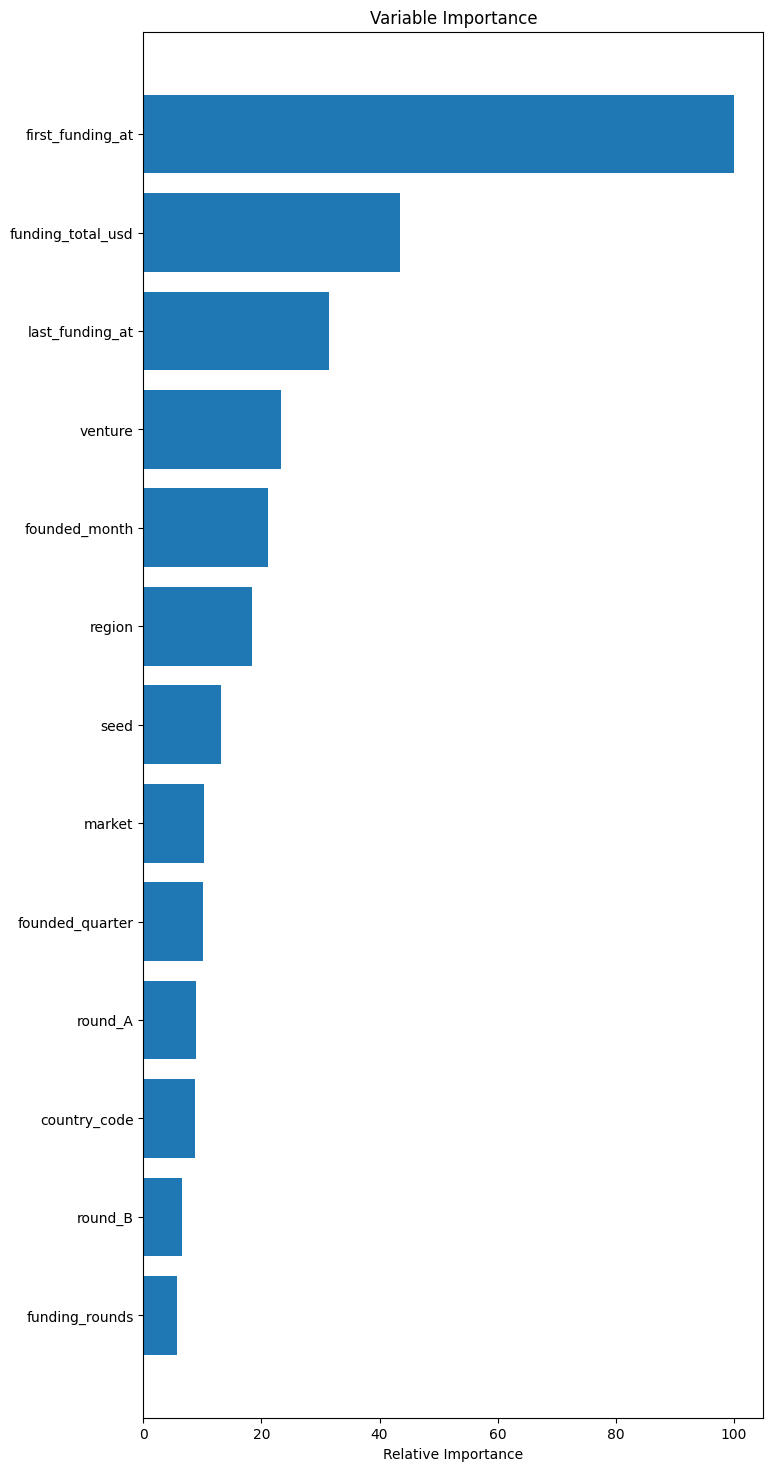

In [16]:
# Plot feature importance - This chart will show how important each company characteristic is for
# predicting an acquisition
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Visualize Model Performance

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

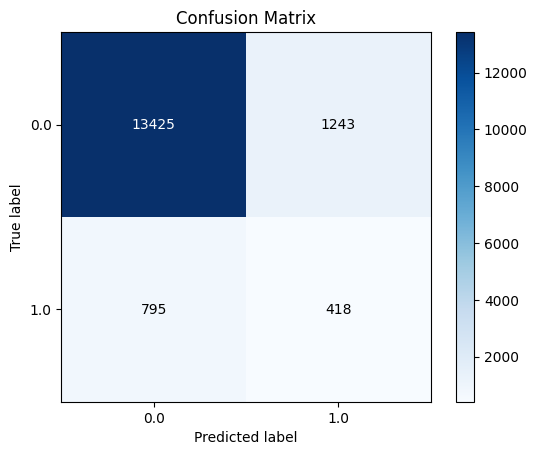

In [22]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred, normalize=False, title = 'Confusion Matrix')

### Case Study - Putting the model to work

Imagine there are three companies. The first is an American software company from San Francisco with 10M USD in total funding since its first funding in 2020. The second company is an Austrian Biotech company with 50M USD in total funding since its first funding in 2018. Finally, the last company is a Canadian E-commerce company with 1.75M USD in total funding since its first funding in 2012. Let's use the model to predict which of these companies will be acquired. The Excel uploaded in the next step contains all the data on the companies.

In [96]:
cs_data = pd.read_excel('Case_study.xlsx')

In [97]:
cs_data

,market,funding_total_usd,status,country_code,region,funding_rounds,founded_month,founded_quarter,first_funding_at,last_funding_at,seed,venture,round_A,round_B
0,1,1000000,NaN,1,1,1,4,2,2020,2020,1000000,0,0,0
1,2,50000000,NaN,0,6,2,1,1,2018,2021,10000000,10000000,10000000,20000000
2,3,1750000,NaN,0,6,1,4,2,2012,2012,1750000,0,0,0


In [98]:
X_cs_Test = cs_data.drop('status', axis=1)

In [99]:
y_cs_test_pred = model.predict(X_cs_Test)

In [100]:
y_cs_test_pred

array([0., 0., 1.])

Thus, we see that out of the three companies, only the Canadian E-commerce company is acquired.

### Hyperparameter Tuning

In [ ]:
# Set up the random search for hyperparameter tuning

random_param_grid = {'max_depth': range(10,50),
                     'learning_rate': uniform(0,1),
                     'max_leaf_nodes': range(1,100)}

random = RandomizedSearchCV(estimator=gbt, param_distributions=random_param_grid,
                            n_iter=10, cv=3, verbose=3, scoring= 'accuracy', error_score='raise')



random.fit(X_train_ros,y_train_ros)

random.best_score_

random.best_params_

random.best_estimator_


# First Run:
# GradientBoostingClassifier(learning_rate=0.6468613736561171, max_depth=40,max_leaf_nodes=95, random_state=147017)
# Second Run with 14 features:
# GradientBoostingClassifier(learning_rate=0.5847829080787613, max_depth=28, max_leaf_nodes=95, random_state=147017)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END learning_rate=0.5847829080787613, max_depth=28, max_leaf_nodes=95;, score=0.945 total time=  14.4s
[CV 2/3] END learning_rate=0.5847829080787613, max_depth=28, max_leaf_nodes=95;, score=0.946 total time=  10.1s
[CV 3/3] END learning_rate=0.5847829080787613, max_depth=28, max_leaf_nodes=95;, score=0.947 total time=   9.8s
[CV 1/3] END learning_rate=0.7855372173583877, max_depth=11, max_leaf_nodes=95;, score=0.942 total time=  16.2s
[CV 2/3] END learning_rate=0.7855372173583877, max_depth=11, max_leaf_nodes=95;, score=0.947 total time=  13.0s
[CV 3/3] END learning_rate=0.7855372173583877, max_depth=11, max_leaf_nodes=95;, score=0.946 total time=  13.7s
[CV 1/3] END learning_rate=0.3340109334832142, max_depth=22, max_leaf_nodes=94;, score=0.936 total time=  10.1s
[CV 2/3] END learning_rate=0.3340109334832142, max_depth=22, max_leaf_nodes=94;, score=0.940 total time=   9.5s
[CV 3/3] END learning_rate=0.33401093348321

GradientBoostingClassifier(learning_rate=0.5847829080787613, max_depth=28,
                           max_leaf_nodes=95, random_state=147017)

In [ ]:
# Save latest verion of model as pickle file
import pickle

# Save the model
with open('model.pkl', 'wb') as f:
  pickle.dump(model, f)